In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import tilemapbase
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

import seaborn as sns
import shapely.speedups
shapely.speedups.enable()


In [2]:
points = gpd.read_file("./data/gis_osm_pois_free_1.shp")


In [3]:
type(points)

geopandas.geodataframe.GeoDataFrame

In [4]:
points.head()

,osm_id,code,fclass,name,geometry
0,26605021,2004,post_box,None,POINT (4.89669 52.35938)
1,26611122,2081,university,UvA Faculteit der Economische Wetenschappen en...,POINT (4.91154 52.36377)
2,26611707,2722,museum,Tropenmuseum,POINT (4.92268 52.36277)
3,26612532,2002,fire_station,Kazerne Victor,POINT (4.92917 52.36046)
4,26654664,2082,school,OBS IJplein,POINT (4.91320 52.38133)


In [5]:
points = points.to_crs({"init": "EPSG:3857"})

/home/gino/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
points = points[points["fclass"] == "restaurant"]

In [7]:
city = gpd.read_file("./data/boundaries/geojson.json")


In [8]:
city = city.to_crs({"init": "EPSG:3857"})
#
city.set_crs(epsg=3857, inplace=True)

,Stadsdeel_code,Stadsdeel,Opp_m2,geometry
0,A,Centrum,8043500,"POLYGON ((549136.599 6867376.523, 549133.148 6..."
1,B,Westpoort,28991600,"POLYGON ((543892.115 6872660.218, 543540.457 6..."
2,E,West,10629900,"POLYGON ((544918.815 6870710.847, 544873.285 6..."
3,F,Nieuw-West,38015500,"POLYGON ((539955.524 6866252.019, 539951.183 6..."
4,K,Zuid,17274000,"POLYGON ((547134.629 6862225.476, 547129.731 6..."
5,M,Oost,30594900,"POLYGON ((560946.039 6864490.649, 560918.543 6..."
6,N,Noord,63828800,"POLYGON ((565410.507 6870704.099, 564865.041 6..."
7,T,Zuidoost,22113700,"POLYGON ((558996.500 6854997.221, 558987.372 6..."


In [9]:
points = gpd.sjoin(points, city, how="left")
points = points.dropna(subset=["index_right"])

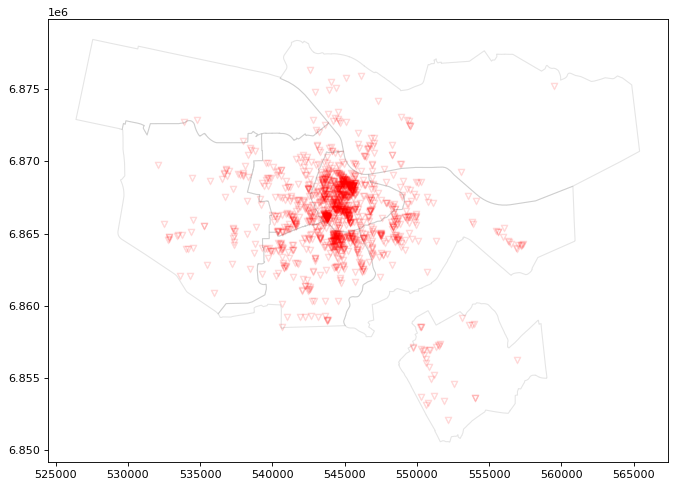

In [10]:
# edit the figure size however you need to

plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')

# create plot and axes

fig = plt.plot()
ax1 = plt.axes()

# these values can be changed as needed, the markers are LaTeX symbols

city.plot(ax=ax1, alpha=0.1, edgecolor="black", facecolor="white")
points.plot(ax=ax1, alpha = 0.1, color="red", marker='$\\bigtriangledown$',)
ax1.figure.savefig('./data/plot1.png', bbox_inches='tight')

In [11]:
bounding_box = [points["geometry"].x.min(), 
                points["geometry"].x.max(), 
                points["geometry"].y.min(), 
                points["geometry"].y.max()]

In [12]:
tilemapbase.start_logging()
tilemapbase.init(create=True)
extent = tilemapbase.extent_from_frame(city, buffer = 25)

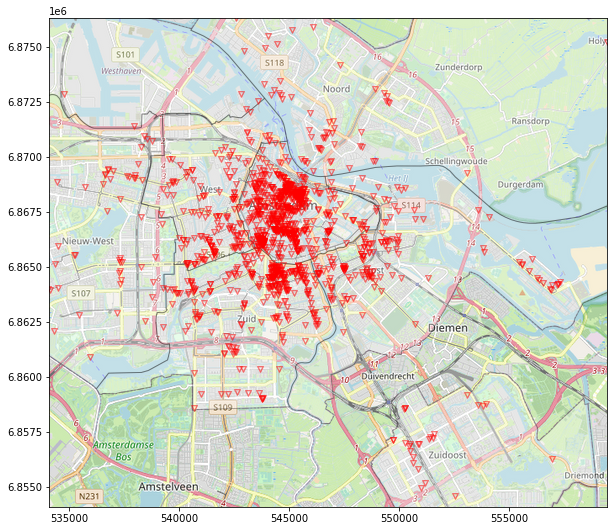

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
points.plot(ax=ax, alpha = 0.4, color="red", marker='$\\bigtriangledown$',)
ax.figure.savefig('./data/plot1.png', bbox_inches='tight')


In [14]:
def plot_map(fig, ax, points_plot, polygons_plot, file_name):
    """
    A short helper function that takes points and polygons as input and 
    creates a plot with a basemap.
    """
    plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
    plotter.plot(ax)
    ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
    ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
    polygons_plot
    points_plot
    ax.figure.savefig(f'./data/{file_name}.png', bbox_inches='tight')


/home/gino/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gino/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


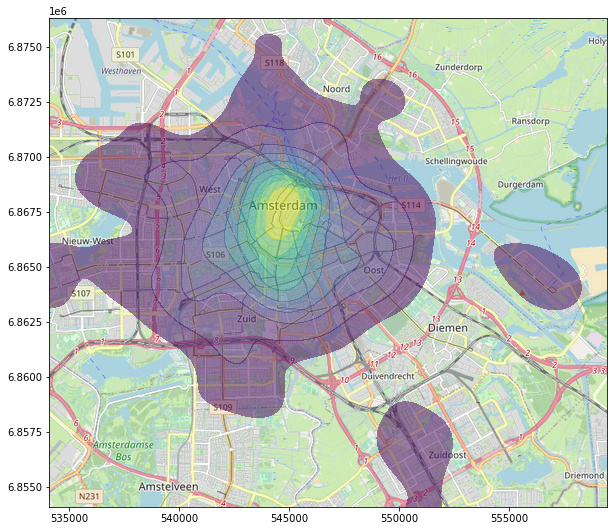

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
density_plot = sns.kdeplot(
                points["geometry"].x,
                points["geometry"].y,
                shade=True,
                alpha=0.5,
                cmap="viridis",
                shade_lowest=False,
                zorder=3
                )
plot_map(fig, ax, density_plot, bounding_box, "plot3")


In [16]:
xy = np.vstack([points["geometry"].x,points["geometry"].y])
z = gaussian_kde(xy)(xy)

In [17]:
points["geometry"].y.shape

(1434,)

In [18]:
z.shape

(1434,)

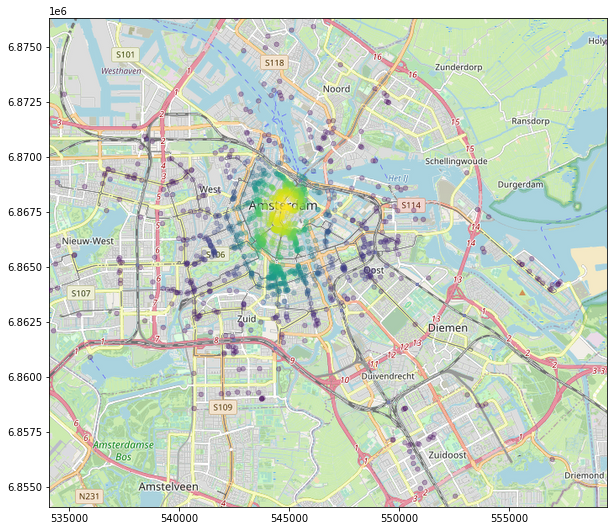

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
points_density = ax.scatter(
                    points["geometry"].x,
                    points["geometry"].y,
                    c=z,
                    s=20,
                    alpha=0.3,
                    zorder=3
                    )
plot_map(fig, ax, points_density, bounding_box, "plot4")